# Forecasting Covid Deaths & Cases in the US
The aim of this project is to use current Covid figures for both deaths and cases as well as indepedendent variables such as (1) urban vs. rural distinctions (2) length and presence of lockdowns (3) prevalence of high-risk diseases (e.g. diabetes) (4) the demographics breakdown (e.g. proportions of youth and elderly in society) (5) Relative poverty levels (6) urban vs. rural distinctions to produce an accurate forecast of the expected covid cases.

In [1]:
import requests
import json
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from IPython.core.interactiveshell import InteractiveShell #This package and the command below allow for the Jupyter notebook
#to print all the outputs and NOT just the final row
InteractiveShell.ast_node_interactivity = "all" #this command allows all outputs to be printed, not just the last command
# Show plots inline
%matplotlib inline

# Loading the data and double checking my headers
In this section I am loading my data which sits in my local desktop using absolute references to the CSV files that are specified below. The last file I uploaded is my mapping file which I will be using to ensure I have perform inner joins on all databases

In [2]:
#Covid Daily cases from 2020-03-23 to 2020-11-30
covid_cases = pd.read_csv(r'C:\Users\MarceloFuentes\Documents\Springboard\Research Project - Covid Patterns\Github - Covid Data\Github-CovidData-20200323-20201130.csv')
print(covid_cases.columns)
covid_cases.head()
# #Lockdown dates with final end date as 2020-11-30
lockdown_dates = pd.read_csv(r'C:\Users\MarceloFuentes\Documents\Springboard\Research Project - Covid Patterns\Covid_Lockdown_Dates\Lockdown_Dates_US_DataFrame.csv')
print(lockdown_dates.columns)
#Proportion of the population by age bracket by county
demographic_ratios = pd.read_csv(r'C:\Users\MarceloFuentes\Documents\Springboard\Research Project - Covid Patterns\Census Bureau - Data by County\ACSST1Y2018.S0101_data_with_overlays_2020-11-02T191057_V2.csv')
print(demographic_ratios.columns)
#Disease data
disease_data = pd.read_csv(r'C:\Users\MarceloFuentes\Documents\Springboard\Research Project - Covid Patterns\CDC Data on obesity\Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv')
print(disease_data.columns)
#Education data
education_data = pd.read_csv(r'C:\Users\MarceloFuentes\Documents\Springboard\Research Project - Covid Patterns\Bureau of Labor Statistics - Unemployment, Education, Poverty, etc\Education.csv')
print(education_data.columns)
#Poverty and income data > MEDHHINC_2018 = Med. Household Inc., PCTPOVALL_2018 = % of pop in poverty
poverty_incomes = pd.read_csv(r'C:\Users\MarceloFuentes\Documents\Springboard\Research Project - Covid Patterns\Bureau of Labor Statistics - Unemployment, Education, Poverty, etc\PovertyEstimates.csv')
print(poverty_incomes.columns)
#Urban/Rural & Unemp. rate > Metro(Metro = 1),Unem_rate_2019, Med_HH_Inc_%_2018, Med_HH_Inc_2018
urb_rural_unem = pd.read_csv(r'C:\Users\MarceloFuentes\Documents\Springboard\Research Project - Covid Patterns\Bureau of Labor Statistics - Unemployment, Education, Poverty, etc\Unemployment.csv')
print(urb_rural_unem.columns)
#State codes and mappings
state_codes_mapping = pd.read_csv(r'C:\Users\MarceloFuentes\Documents\Springboard\Research Project - Covid Patterns\States and Codes Mappings\State Names Codes and Mappings.csv')
print(state_codes_mapping.columns)


Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio',
       'Incident_Rate', 'Case_Fatality_Ratio'],
      dtype='object')


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio
0,36061,New York City,New York,US,3/22/2020 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US",NaN,NaN,NaN,NaN
1,36059,Nassau,New York,US,3/22/2020 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US",NaN,NaN,NaN,NaN
2,36119,Westchester,New York,US,3/22/2020 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US",NaN,NaN,NaN,NaN
3,36103,Suffolk,New York,US,3/22/2020 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US",NaN,NaN,NaN,NaN
4,36087,Rockland,New York,US,3/22/2020 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US",NaN,NaN,NaN,NaN


Index(['GEO_ID', 'NAME', 'STATE', '2_LETTER_CODE', 'FINAL_START_DATE',
       'FINAL_END_DATE', 'FIPS', 'State'],
      dtype='object')
Index(['id', 'FIPS', 'Geographic Area Name',
       'Estimate!!Total!!Total population',
       'Margin of Error!!Total MOE!!Total population',
       'Estimate!!Percent!!Total population',
       'Margin of Error!!Percent MOE!!Total population',
       'Estimate!!Male!!Total population',
       'Margin of Error!!Male MOE!!Total population',
       'Estimate!!Percent Male!!Total population',
       ...
       'Estimate!!Percent!!PERCENT ALLOCATED!!Age',
       'Margin of Error!!Percent MOE!!PERCENT ALLOCATED!!Age',
       'Estimate!!Male!!PERCENT ALLOCATED!!Age',
       'Margin of Error!!Male MOE!!PERCENT ALLOCATED!!Age',
       'Estimate!!Percent Male!!PERCENT ALLOCATED!!Age',
       'Margin of Error!!Percent Male MOE!!PERCENT ALLOCATED!!Age',
       'Estimate!!Female!!PERCENT ALLOCATED!!Age',
       'Margin of Error!!Female MOE!!PERCENT ALLOCATED!!Ag

# Data clustering and cleaning
In this section I am clustering some of my data (e.g. the demographic ratios) into smaller datasets, the education data had some headers with apostrophes in it that needed to be removed, and I downsized my dataframes to include only the columns I deemed necessary in order to make the join process quicker/more efficient

In [3]:
#These are the downsized dataframes
#Covid cases
covid_cases.head()
#Proportion of the population by age bracket by county
demographic_ratios['Percent_over_65'] = demographic_ratios['Estimate!!Percent!!Total population!!AGE!!85 years and over']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!80 to 84 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!75 to 79 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!70 to 74 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!65 to 69 years']                              
demographic_ratios['Percent_between_20and64'] = demographic_ratios['Estimate!!Percent!!Total population!!AGE!!60 to 64 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!55 to 59 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!50 to 54 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!45 to 49 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!40 to 44 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!35 to 39 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!30 to 34 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!25 to 29 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!20 to 24 years']
demographic_ratios['Percent_19_and_below'] = demographic_ratios['Estimate!!Percent!!Total population!!AGE!!15 to 19 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!10 to 14 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!5 to 9 years']+demographic_ratios['Estimate!!Percent!!Total population!!AGE!!Under 5 years']
demographic_ratios = demographic_ratios [['id','FIPS','Geographic Area Name','Percent_19_and_below','Percent_between_20and64','Percent_over_65']]
demographic_ratios.head()
#Disease data
disease_data = disease_data[['Data_Value','Question','LocationDesc','LocationAbbr']] 
disease_data.head()
#Education data
education_data.columns = education_data.columns.str.replace("'","")
education_data = education_data[['FIPS Code', 'State', 'Area name','Percent of adults with less than a high school diploma, 2014-18',
       'Percent of adults with a high school diploma only, 2014-18',
       'Percent of adults completing some college or associates degree, 2014-18',
       'Percent of adults with a bachelors degree or higher, 2014-18']] 
education_data.head()
# #Poverty and income data > MEDHHINC_2018 = Med. Household Inc., PCTPOVALL_2018 = % of pop in poverty
poverty_incomes = poverty_incomes[['FIPStxt', 'Stabr', 'Area_name','PCTPOVALL_2018','MEDHHINC_2018']]
poverty_incomes.head()
# #Urban/Rural & Unemp. rate > Metro(Metro = 1),Unem_rate_2019, Med_HH_Inc_%_2018, Med_HH_Inc_2018
urb_rural_unem = urb_rural_unem[['FIPStxt', 'Stabr', 'area_name','Metro_2013','Unemployment_rate_2019','Median_Household_Income_2018','Med_HH_Income_Percent_of_State_Total_2018']]
urb_rural_unem.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Incident_Rate,Case_Fatality_Ratio
0,36061,New York City,New York,US,3/22/2020 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US",NaN,NaN,NaN,NaN
1,36059,Nassau,New York,US,3/22/2020 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US",NaN,NaN,NaN,NaN
2,36119,Westchester,New York,US,3/22/2020 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US",NaN,NaN,NaN,NaN
3,36103,Suffolk,New York,US,3/22/2020 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US",NaN,NaN,NaN,NaN
4,36087,Rockland,New York,US,3/22/2020 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US",NaN,NaN,NaN,NaN


,id,FIPS,Geographic Area Name,Percent_19_and_below,Percent_between_20and64,Percent_over_65
0,0500000US01117,1117,"Shelby County, Alabama",25.1,59.4,15.4
1,0500000US01121,1121,"Talladega County, Alabama",24.2,57.7,18.1
2,0500000US01125,1125,"Tuscaloosa County, Alabama",27.9,58.8,13.2
3,0500000US04021,4021,"Pinal County, Arizona",24.8,54.9,20.3
4,0500000US06045,6045,"Mendocino County, California",23.7,54.4,21.9


,Data_Value,Question,LocationDesc,LocationAbbr
0,29.5,Percent of adults aged 18 years and older who ...,Alaska,AK
1,30.9,Percent of adults aged 18 years and older who ...,Maryland,MD
2,30.4,Percent of adults aged 18 years and older who ...,Virginia,VA
3,29.8,Percent of adults aged 18 years and older who ...,Guam,GU
4,34.8,Percent of adults aged 18 years and older who ...,Oklahoma,OK


,FIPS Code,State,Area name,"Percent of adults with less than a high school diploma, 2014-18","Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associates degree, 2014-18","Percent of adults with a bachelors degree or higher, 2014-18"
0,0,US,United States,12.3,27.1,29.0,31.5
1,1000,AL,Alabama,14.2,30.9,29.9,24.9
2,1001,AL,Autauga County,11.3,32.6,28.4,27.7
3,1003,AL,Baldwin County,9.7,27.6,31.3,31.3
4,1005,AL,Barbour County,27.0,35.7,25.1,12.2


,FIPStxt,Stabr,Area_name,PCTPOVALL_2018,MEDHHINC_2018
0,0,US,United States,13.1,"61,937"
1,1000,AL,Alabama,16.8,"49,881"
2,1001,AL,Autauga County,13.8,"59,338"
3,1003,AL,Baldwin County,9.8,"57,588"
4,1005,AL,Barbour County,30.9,"34,382"


,FIPStxt,Stabr,area_name,Metro_2013,Unemployment_rate_2019,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,0,US,United States,NaN,3.7,"61,937",NaN
1,1000,AL,Alabama,NaN,3.0,"49,881",100.0
2,1001,AL,"Autauga County, AL",1.0,2.7,"59,338",119.0
3,1003,AL,"Baldwin County, AL",1.0,2.7,"57,588",115.5
4,1005,AL,"Barbour County, AL",0.0,3.8,"34,382",68.9


# Data joining & downsizing
In this section I am converting the FIPS (Federal Information Processing Standard) codes which identify every US state and county to the string type so I can perform an inner join of all the tables involved and get them into a single dataframe.

In [54]:
#Pass all the FIPS codes to the same data type to perform joins
covid_cases['FIPS'] = covid_cases['FIPS'].astype(str)
demographic_ratios['FIPS'] = demographic_ratios['FIPS'].astype(str) 
education_data['FIPS Code'] = education_data['FIPS Code'].astype(str)
poverty_incomes['FIPStxt'] = poverty_incomes['FIPStxt'].astype(str)
urb_rural_unem['FIPStxt'] = urb_rural_unem['FIPStxt'].astype(str)
state_codes_mapping['FIPS'] = state_codes_mapping['FIPS'].astype(str)
lockdown_dates['FIPS'] = lockdown_dates['FIPS'].astype(str)

# Covid Cases -> pass FIPS to str
# demographic ratios -> pass FIPS to str
# education data -> pass FIPS code to str
# poverty_incomes -> pass FIPStxt to str
# urb_rural_unem -> pass FIPStxt to str
# states_codes_mapping-> pass State_FIPS to str
df = pd.merge(covid_cases,state_codes_mapping, how='inner', left_on='FIPS', right_on='FIPS')
df = pd.merge(df, demographic_ratios, how='inner', left_on='FIPS', right_on='FIPS')
df = pd.merge(df, education_data, how='inner', left_on='FIPS', right_on='FIPS Code')
df = pd.merge(df, poverty_incomes, how='inner', left_on='FIPS', right_on='FIPStxt')
df = pd.merge(df, urb_rural_unem, how='inner', left_on='FIPS', right_on='FIPStxt')
df = pd.merge(df, lockdown_dates, how='inner', left_on='FIPS', right_on='FIPS')

df.columns
df = df[['FIPS', 'Admin2', 'Country_Region','2_LETTER_CODE', 'Last_Update',
         'Confirmed', 'Deaths', 'Recovered', 'Active',
         'Incidence_Rate', 'Case-Fatality_Ratio',
       'Incident_Rate', 'Case_Fatality_Ratio', 'State_x', 'Code', 'id',
       'Percent_19_and_below',
       'Percent_between_20and64', 'Percent_over_65','State_y',
       'Percent of adults with less than a high school diploma, 2014-18',
       'Percent of adults with a high school diploma only, 2014-18',
       'Percent of adults completing some college or associates degree, 2014-18',
       'Percent of adults with a bachelors degree or higher, 2014-18',
       'PCTPOVALL_2018','Metro_2013',
       'Unemployment_rate_2019', 'Median_Household_Income_2018',
       'Med_HH_Income_Percent_of_State_Total_2018','FINAL_START_DATE',
        'FINAL_END_DATE']]
df.head()
# print(df.head())
# demographic_ratios
# disease_data
# education_data
# poverty_incomes
# urb_rural_unem
# covid_cases


Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio',
       'Incident_Rate', 'Case_Fatality_Ratio', 'State_x', 'Code', 'id',
       'Geographic Area Name', 'Percent_19_and_below',
       'Percent_between_20and64', 'Percent_over_65', 'FIPS Code', 'State_y',
       'Area name',
       'Percent of adults with less than a high school diploma, 2014-18',
       'Percent of adults with a high school diploma only, 2014-18',
       'Percent of adults completing some college or associates degree, 2014-18',
       'Percent of adults with a bachelors degree or higher, 2014-18',
       'FIPStxt_x', 'Stabr_x', 'Area_name', 'PCTPOVALL_2018', 'MEDHHINC_2018',
       'FIPStxt_y', 'Stabr_y', 'area_name', 'Metro_2013',
       'Unemployment_rate_2019', 'Median_Household_Income_2018',
       'Med_HH_Income_Percent_of_State_Total_2018', 'GEO_ID', 'NAME',

,FIPS,Admin2,Country_Region,2_LETTER_CODE,Last_Update,Confirmed,Deaths,Recovered,Active,Incidence_Rate,...,"Percent of adults with a high school diploma only, 2014-18","Percent of adults completing some college or associates degree, 2014-18","Percent of adults with a bachelors degree or higher, 2014-18",PCTPOVALL_2018,Metro_2013,Unemployment_rate_2019,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,FINAL_START_DATE,FINAL_END_DATE
0,36061,New York City,US,NY,3/22/2020 23:45,9654,63,0,0,NaN,...,12.4,13.7,60.8,15.6,1.0,3.5,"84,610",125.1,22-03-2020,15-05-2020
1,36061,New York City,US,NY,3/22/2020 23:45,9654,63,0,0,NaN,...,12.4,13.7,60.8,15.6,1.0,3.5,"84,610",125.1,22-03-2020,15-05-2020
2,36061,New York City,US,NY,3/23/2020 23:19,12305,99,0,0,NaN,...,12.4,13.7,60.8,15.6,1.0,3.5,"84,610",125.1,22-03-2020,15-05-2020
3,36061,New York City,US,NY,3/23/2020 23:19,12305,99,0,0,NaN,...,12.4,13.7,60.8,15.6,1.0,3.5,"84,610",125.1,22-03-2020,15-05-2020
4,36061,New York City,US,NY,3/24/2020 23:37,14904,131,0,0,NaN,...,12.4,13.7,60.8,15.6,1.0,3.5,"84,610",125.1,22-03-2020,15-05-2020


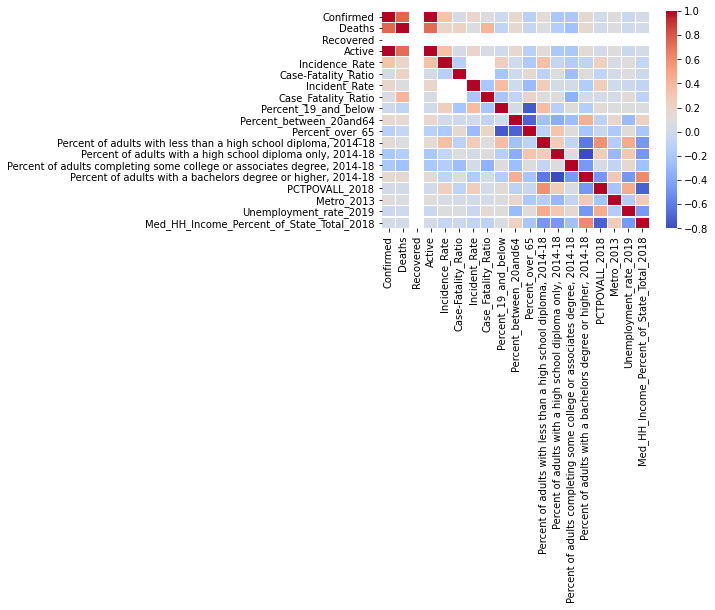

In [48]:
#correlation matrix 1
#Create a correlation heatmap for looking at the correlation of all variables/features
corrmat = df.corr()
hm = sns.heatmap(round(corrmat,2), cmap="coolwarm",
                 linewidths=.05)
figsize = (60,60)


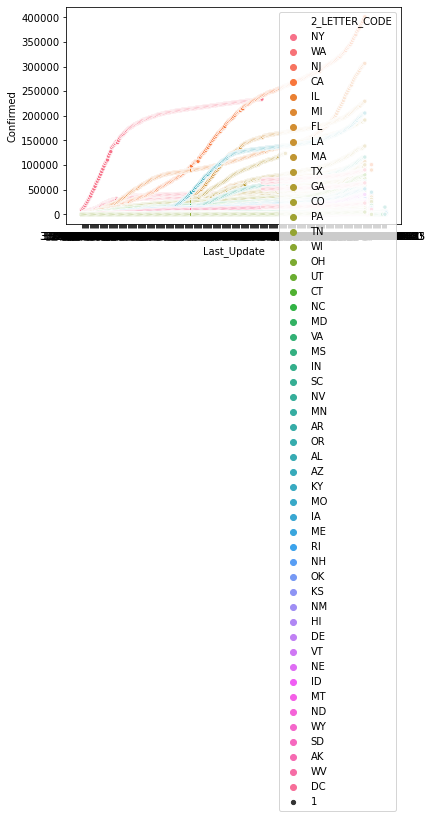

In [66]:
#Histogram matrix to analyze my data distributions
sns.scatterplot(x=df['Last_Update'],y=df['Confirmed'],size=1, hue=df['2_LETTER_CODE'])
# plt.title("Confirmed cases vs. Deaths")
# plt.xlabel("Deaths")
# plt.ylabel("Confirmed Cases")
# plt.show()

# Conclusions so far
We have some strong correlations between a couple of our dependent variables which might later be used as independent variables using an auto-regressive correlation. Additionally, while the rest of the independent variables did not show a strong correlation to our depedent variables (mainly due to the mismatch in time series - e.g. yearly vs daily) for now we will keep them handy for the next step, but cannot draw any major conclusions from it so far. Lastly, as it relates to further variables which could be added to this EDA piece, I think I might include daily weather patterns in the next step to see if I can get a closer correlation to Covid cases as well as a date variable to account for major US holidays which is when we see the spike in cases. 

Additionally, the states of New York, Washington, New Jersey and California stand out from the rest of the group as the ones with the most cases and deaths, however this should be adjusted against the total population of these states, furthermore, so far this EDA has yet to fully delve into the specific of every single county in the group.

Lastly, as it relates to correlations between some of my independent variables, I noticed that there are strong correlations between income/poverty indices and the percentage of adults without a college education as well as those without a high school degree. Therefore, I might be inclined to remove one of these two variables in my model to avoid overfitting.